One idea put forward is to vary exposure time in order to keep constant depth. What range of exposure times would be needed?

In [1]:
# Check range of delivered m5 values.
import lsst.sims.maf.db as db

In [2]:
opsdb = db.OpsimDatabase('db/kraken_2026.db')

In [3]:
# Which proposal is WFD?
opsdb.fetchPropInfo()

({1: 'GalacticPlane',
  2: 'SouthCelestialPole',
  3: 'WideFastDeep',
  4: 'NorthEclipticSpur',
  5: 'DeepDrillingCosmology1'},
 {'WFD': [3], 'DD': [5], 'NES': [4]})

In [4]:
# What is the range in visit depths, in WFD, in our typical (baseline-style) opsim?
simdata = {}
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    simdata[f] = opsdb.fetchMetricData(['fiveSigmaDepth'], sqlconstraint='filter="%s" and proposalId=3' % f)
    print(f, simdata[f]['fiveSigmaDepth'].min(), simdata[f]['fiveSigmaDepth'].max(), 
          simdata[f]['fiveSigmaDepth'].max() - simdata[f]['fiveSigmaDepth'].min())

u 22.0943205354 24.0837842178 1.98946368236
g 23.3683127426 25.4036678373 2.03535509471
r 23.0211931225 24.9577335537 1.93654043124
i 22.5148415198 24.4080723472 1.89323082739
z 21.5716850092 23.7059561892 2.13427118004
y 20.5829214879 22.735065822 2.15214433407


This tells us that the range in limiting magnitude can be as much as 2.1 mags in the WFD (but this doesn't include clouds). 

In [5]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

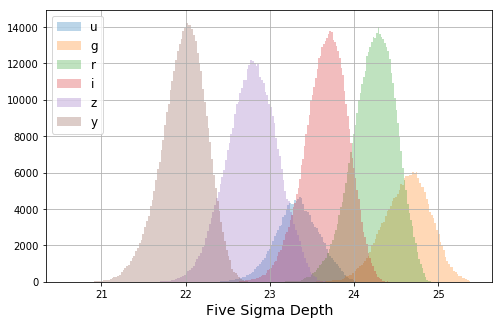

In [7]:
# What does this distribution look like, and what is the mean/median/mode?
plt.figure(figsize=(8, 5))
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    plt.hist(simdata[f]['fiveSigmaDepth'], bins=100, alpha=0.3, label=f)
plt.legend(loc='upper left', fancybox=True, fontsize='large')
plt.grid(True)
plt.xlabel("Five Sigma Depth", fontsize='x-large')

In [8]:
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    print(f, np.mean(simdata[f]['fiveSigmaDepth']), 
          np.median(simdata[f]['fiveSigmaDepth']), 
          stats.mode(simdata[f]['fiveSigmaDepth'])[0])

u 23.3229643462 23.3270668852 [ 22.09432054]
g 24.6285137018 24.6446753981 [ 23.36831274]
r 24.2393483281 24.2548123015 [ 23.02119312]
i 23.6646898088 23.6807466275 [ 22.51484152]
z 22.7869287131 22.7941917243 [ 21.57168501]
y 21.9779197958 21.9952508039 [ 20.58292149]


In [9]:
wfd_mode = {'u': 22.1, 'g': 23.4, 'r': 23.0, 'i': 22.5, 'z': 21.6, 'y': 20.6}
wfd_median = {'u': 23.3, 'g': 24.6, 'r': 24.3, 'i': 23.7, 'z': 22.8, 'y': 22.0}

In [10]:
# Calculate how exposure time should vary ..
import lsst.syseng.throughputs as st

In [11]:
defaultDirs = st.setDefaultDirs()
hardware, system = st.buildHardwareAndSystem(defaultDirs)

In [12]:
# Calculate m5 in ideal conditions, show all output.
st.makeM5(hardware, system, darksky=None, exptime=30, nexp=1, X=1.0)

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.989546,70.402589,26.900947,0.032437,0.051867,0.509618,0.037738,23.281862,0.409256,0.246092,23.979911,442.115544,23.9,23.4
g,0.87,0.76714,22.255978,406.358769,28.385271,0.127284,0.152329,0.195029,0.038644,24.517163,0.099552,0.049917,24.909100,737.207358,25.0,24.6
r,0.83,0.73426,21.197245,812.576131,28.169626,0.104355,0.114880,0.104326,0.038945,24.507227,0.052338,0.024335,24.420899,947.571405,24.7,24.3
i,0.80,0.70960,20.476708,1144.015607,27.851170,0.077827,0.083291,0.073665,0.039063,24.379825,0.037756,0.016734,23.973200,1067.356394,24.0,23.6
z,0.78,0.69316,19.599918,1715.474293,27.440200,0.053302,0.055697,0.047725,0.039205,24.201710,0.025521,0.010600,23.384178,1257.564036,23.3,22.9
y,0.76,0.67672,18.611865,2283.488487,26.647213,0.025677,0.029842,0.163195,0.039288,23.754929,0.019306,0.007553,22.471573,1404.033432,22.1,21.7


In [13]:
# Calculate difference in m5 if you increase the number of exposures in a visit. 
# Going up to 7x30s exposures instead of 1 means increase in limiting mag of 1.06
st.makeM5(hardware, system, darksky=None, exptime=30, nexp=7, X=1.0).m5 - \
st.makeM5(hardware, system, darksky=None, exptime=30, nexp=1, X=1.0).m5

u    1.076027
g    1.068022
r    1.065401
i    1.064376
z    1.063153
y    1.062439
Name: m5, dtype: float64

In [14]:
# But you need more like 40 exposures to be constant over 2 magnitudes.
st.makeM5(hardware, system, darksky=None, exptime=30, nexp=40, X=1.0).m5 - \
st.makeM5(hardware, system, darksky=None, exptime=30, nexp=1, X=1.0).m5

u    2.029177
g    2.018343
r    2.014795
i    2.013407
z    2.011752
y    2.010786
Name: m5, dtype: float64

Another suggestion is to vary the visit length *slightly* in order to keep things more uniform, but not absolutely uniform. The limits in this case could be 20-60s, with exposures becoming shorter when expected depth is better than the mode.

In [41]:
depth_change = {}
m20 = st.makeM5(hardware, system, darksky=None, exptime=20, nexp=1, X=1.0)
m30 = st.makeM5(hardware, system, darksky=None, exptime=30, nexp=1, X=1.0)
m60 = st.makeM5(hardware, system, darksky=None, exptime=60, nexp=1, X=1.0)

In [42]:
for f in ('u', 'g', 'r', 'i', 'z', 'y'):
    if f == 'u':
        print("30 to 60s in u:" ,m60['m5']['u'] - m30['m5']['u'])
    else:
        print("20 to 60s in %s:" % f ,m60['m5'][f] - m20['m5'][f])
    

30 to 60s in u: 0.539450851368
20 to 60s in g: 0.690692789186
20 to 60s in r: 0.650261080659
20 to 60s in i: 0.636932540984
20 to 60s in z: 0.625191433412
20 to 60s in y: 0.619059376478


So this means that changing between 20-60 seconds can compensate for a change in magnitude of about 0.6-0.7 magnitudes in depth.